# Extract (Text Extraction)
## 📚 강의 개요 (Overview)

본 강의에서는 다양한 형식(PDF, 웹페이지, CSV, DOCX, PPT 등)의 데이터를 LangChain을 활용하여 로드하는 방법을 배우고,  
각 데이터 유형별 문서 처리 방식을 실습합니다.

**내용 요약**:
- LangChain의 다양한 **Document Loaders** 사용법
- PDF, 웹페이지, CSV, DOCX, PPTX로부터 텍스트를 로딩
- 데이터프레임 및 AI 에이전트(Agent)를 결합한 자동화된 분석/시각화 예시

**목차**

* [PDF 파일에서 문서 로드하기](#pdf-파일에서-문서-로드하기)  
* [웹 페이지에서 콘텐츠 추출하기](#웹-페이지에서-콘텐츠-추출하기)  
* [CSV 파일 데이터 로드 및 분석하기](#csv-파일-데이터-로드-및-분석하기)
* [PowerPoint 문서 로드하기](#powerpoint-문서-로드하기)


In [ ]:
#  필요한 패키지 설치
# %pip install -qU \
#     pypdf \
#     langchain-community \
#     unstructured \
#     bs4 \
#     unstructured \
#     lxml \
#     python-docx \
#     langchain-experimental \
#     python-pptx \
#     matplotlib \
#     seaborn \
#     python-dotenv \
#     langchain-community unstructured

In [4]:
# 환경변수 설정하기 (.env 파일을 사용하지 않을 경우 여기에 입력해주세요!)
import os

# 환경변수 설정
os.environ["API_KEY"] = "sk-..."

In [5]:
# 환경변수 불러오기
from dotenv import load_dotenv
load_dotenv(override=True)

True

## PDF 파일에서 문서 로드하기

LangChain의 **PyPDFLoader**를 이용하여  
**PDF 파일**에서 **페이지 단위**로 텍스트를 추출하는 방법을 살펴봅시다.

In [6]:
# %pip install -qU pypdf langchain-community langchain-unstructured

In [7]:
# 사용할 PDF 파일의 경로 설정
file_path = "data/arxiv_paper.pdf"

from langchain_community.document_loaders import PyPDFLoader

# PyPDFLoader 객체 생성
loader = PyPDFLoader(file_path)

# PDF 파일의 각 페이지 내용을 비동기 방식으로 불러와 저장할 리스트
pages = []

# 비동기 방식으로 PDF의 각 페이지를 로드하며 pages 리스트에 추가
async for page in loader.alazy_load():
    pages.append(page)

# 첫 페이지의 메타데이터와 본문 내용을 출력해보기
print(f"{pages[0].metadata}\n")
print(pages[0].page_content[:500])  # 내용 일부만 출력


{'source': 'data/arxiv_paper.pdf', 'page': 0}

Uncertainty in Action: Confidence Elicitation in Embodied Agents
Tianjiao Yu, Vedant Shah, Muntasir Wahed, Kiet A. Nguyen, Adheesh Juvekar
Tal August, Ismini Lourentzou
University of Illinois Urbana-Champaign
{ty41,vrshah4,mwahed2,kietan2,adheesh2,taugust,lourent2}@illinois.edu
https://plan-lab.github.io/ece
Abstract
Expressing confidence is challenging for embod-
ied agents navigating dynamic multimodal en-
vironments, where uncertainty arises from both
perception and decision-making processes.


## 웹 페이지에서 콘텐츠 추출하기

LangChain의 **WebBaseLoader**를 이용해 인터넷상의 웹 페이지에서 텍스트를 가져올 수 있습니다.

그리고 필요에 따라서 **BeautifulSoup**를 통해 특정 부분(예: 특정 클래스나 태그)만 추출할 수도 있습니다. 

### 1. 기본 웹페이지 로딩 (WebBaseLoader)

LangChain의 `WebBaseLoader`를 사용해
단일 웹페이지에서 텍스트를 로드해보기


In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

page_url = "https://techcrunch.com/2025/03/14/ai-coding-assistant-cursor-reportedly-tells-a-vibe-coder-to-write-his-own-damn-code/"

# LangChain의 WebBaseLoader를 이용해 지정한 URL에서 웹 문서를 로드
loader = WebBaseLoader(web_paths=[page_url])
docs = []

# 비동기 방식으로 문서를 로드하여 docs 리스트에 저장
async for doc in loader.alazy_load():
    docs.append(doc)

# 문서가 정상적으로 로드되었는지 확인 (1개의 문서가 로드되었는지 검사)
assert len(docs) == 1

# 로드한 문서 객체를 변수에 저장
doc = docs[0]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
print(f"{doc.metadata}\n") # 로드된 문서의 메타데이터 출력 (URL 등 부가정보)
print(doc.page_content[:500]) # 문서 본문의 첫 500자 출력

{'source': 'https://techcrunch.com/2025/03/14/ai-coding-assistant-cursor-reportedly-tells-a-vibe-coder-to-write-his-own-damn-code/', 'title': "AI coding assistant Cursor reportedly tells a 'vibe coder' to write his own damn code | TechCrunch", 'description': 'AI coding assistant Cursor reportedly refused to help a user with their code, insisting that they do it themselves.', 'language': 'en-US'}













AI coding assistant Cursor reportedly tells a 'vibe coder' to write his own damn code | TechCrunch


























AI coding assistant Cursor reportedly tells a 'vibe coder' to write his own damn code | TechCrunch













































































 
























 TechCrunch Desktop Logo




 TechCrunch Mobile Logo




LatestStartupsVentureAppleSecurityAIAppsSXSW 2025

EventsPodcastsNewsletters







		Sign In	







Se


### 2. 웹페이지에서 특정 부분만 추출하기

`bs4.SoupStrainer`를 통해 HTML 내 특정 클래스(또는 태그)만 필터링하여 텍스트를 추출할 수 있습니다.
--> 불필요한 정보를 제외하고, **중요한 섹션**만 빠르게 가져올 수 있음.


In [10]:
# WebBaseLoader를 이용하여 웹페이지에서 특정 부분만 추출하는 코드

# loader 객체 초기화
loader = WebBaseLoader(
    web_paths=[page_url],  # 문서를 가져올 웹페이지 URL
    bs_kwargs={
        # BeautifulSoup의 SoupStrainer를 사용해 페이지에서 특정 클래스만 파싱하여 추출
        "parse_only": bs4.SoupStrainer(
            class_="entry-content wp-block-post-content is-layout-constrained wp-block-post-content-is-layout-constrained"
        ),
    },
    # 텍스트를 추출할 때 구분자(separator)를 설정하고 공백을 제거(strip)
    bs_get_text_kwargs={"separator": " | ", "strip": True},
)

# 비동기 방식으로 문서를 로딩하여 리스트에 저장
docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

# 정상적으로 1개의 문서가 로딩되었는지 확인
assert len(docs) == 1

# 로딩된 문서를 변수에 저장
doc = docs[0]

In [11]:
# 문서의 메타데이터 출력 (소스 URL 등)
print(f"{doc.metadata}\n")

# 문서 본문의 처음 500자를 출력하여 추출된 내용 확인
print(doc.page_content[:500])

{'source': 'https://techcrunch.com/2025/03/14/ai-coding-assistant-cursor-reportedly-tells-a-vibe-coder-to-write-his-own-damn-code/'}

As businesses race to replace humans with AI “agents,” coding assistant Cursor may have given us a peek at the attitude bots could bring to work, too. | Cursor reportedly told a user going by the name “janswist” that he should write the code himself instead of relying on Cursor to do it for him. | “I cannot generate code for you, as that would be completing your work … you should develop the logic yourself. This ensures you understand the system and can maintain it properly,” janswist said Curso


### 3. UnstructuredLoader로 웹 페이지에서 NarrativeText만 추출하기

`UnstructuredLoader`는 구조화되지 않은 텍스트를 조금 더 세밀하게 구분하여 로드합니다.
아래 예시에서는 특정 웹페이지에서 텍스트 카테고리가 'NarrativeText'인 항목만 골라내어 출력합니다.


In [13]:
# UnstructuredLoader를 이용하여 웹 페이지에서 구조화되지 않은(Narrative) 텍스트 추출하기

from langchain_unstructured import UnstructuredLoader

# 내용을 가져올 웹 페이지 URL 설정 (LangChain의 메모리 관련 문서)
page_url = "https://python.langchain.com/docs/how_to/chatbots_memory/"

# UnstructuredLoader 객체 초기화 (웹 URL에서 직접 로딩)
loader = UnstructuredLoader(web_url=page_url)

# 문서 데이터를 저장할 리스트 초기화
docs = []

# 비동기 방식으로 문서를 로딩하여 docs 리스트에 추가
async for doc in loader.alazy_load():
    docs.append(doc)

In [15]:
# 로드된 문서에서 텍스트 카테고리가 'NarrativeText'인 항목만 선택하여 출력
for i in docs:
    if i.metadata['category'] == "NarrativeText":
        print(i.page_content)

A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including:
We'll go into more detail on a few techniques below!
This how-to guide previously built a chatbot using RunnableWithMessageHistory. You can access this version of the guide in the v0.2 docs.
As of the v0.3 release of LangChain, we recommend that LangChain users take advantage of LangGraph persistence to incorporate memory into new LangChain applications.
If your code is already relying on RunnableWithMessageHistory or BaseChatMessageHistory, you do not need to make any changes. We do not plan on deprecating this functionality in the near future as it works for simple chat applications and any code that uses RunnableWithMessageHistory will continue to work as expected.
Please see How to migrate to LangGraph Memory for more details.
You'll need to install a few packages, and have your OpenAI API key set as an environment varia

### 4. 특정 섹션(Setup)만 추출하기

아래 함수 `_get_setup_docs_from_url()`는  
문서 구조(제목, 본문 등)를 확인한 뒤,  
`Title` 중에서 `'Setup'`으로 시작하는 항목을 찾고,  
그 **부모 ID** 하위에 속한 문서들을 한곳에 모으는 예시입니다.


In [16]:
from typing import List
from langchain_core.documents import Document


# URL에서 설정 관련 문서를 추출하는 비동기 함수
async def _get_setup_docs_from_url(url: str) -> List[Document]:
    # 웹 URL에서 문서를 로드하는 UnstructuredLoader 초기화
    loader = UnstructuredLoader(web_url=url)

    setup_docs = []
    parent_id = -1
    # 비동기적으로 문서 로드
    async for doc in loader.alazy_load():
        # "Setup"으로 시작하는 제목 문서를 찾아 부모 ID 저장
        if doc.metadata["category"] == "Title" and doc.page_content.startswith("Setup"):
            parent_id = doc.metadata["element_id"]
        # 해당 부모 ID를 가진 문서들을 수집
        if doc.metadata.get("parent_id") == parent_id:
            setup_docs.append(doc)

    return setup_docs


# 설정 정보를 추출할 웹 페이지 URL 목록
page_urls = [
    "https://python.langchain.com/docs/how_to/chatbots_memory/",
    "https://python.langchain.com/docs/how_to/chatbots_tools/",
]
# 모든 설정 문서를 저장할 리스트
setup_docs = []
# 각 URL에서 설정 문서 추출 및 통합
for url in page_urls:
    page_setup_docs = await _get_setup_docs_from_url(url)
    setup_docs.extend(page_setup_docs)

In [17]:
from collections import defaultdict

setup_text = defaultdict(str)

for doc in setup_docs:
    url = doc.metadata["url"]
    setup_text[url] += f"{doc.page_content}\n"

dict(setup_text)

{'https://python.langchain.com/docs/how_to/chatbots_memory/': 'You\'ll need to install a few packages, and have your OpenAI API key set as an environment variable named OPENAI_API_KEY:\n%pip install --upgrade --quiet langchain langchain-openai langgraph\n\nimport getpass\nimport os\n\nif not os.environ.get("OPENAI_API_KEY"):\n    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")\nOpenAI API Key: ········\nLet\'s also set up a chat model that we\'ll use for the below examples.\nfrom langchain_openai import ChatOpenAI\n\nmodel = ChatOpenAI(model="gpt-4o-mini")\nAPI Reference:ChatOpenAI\n',
 'https://python.langchain.com/docs/how_to/chatbots_tools/': 'For this guide, we\'ll be using a tool calling agent with a single tool for searching the web. The default will be powered by Tavily, but you can switch it out for any similar tool. The rest of this section will assume you\'re using Tavily.\nYou\'ll need to sign up for an account on the Tavily website, and install the followi

### 5. RecursiveUrlLoader로 여러 날의 TechCrunch 문서를 한 번에 로드하기

`RecursiveUrlLoader`는 재귀적으로 링크를 따라가며 텍스트를 추출할 수 있습니다.
아래 예시는 최근 7일치 TechCrunch URL을 순회하며 문서를 로딩합니다.

In [18]:
import re
from bs4 import BeautifulSoup
from langchain_community.document_loaders import RecursiveUrlLoader
from datetime import datetime, timedelta


def bs4_extractor(html: str) -> str:
    # BeautifulSoup 객체 생성 (lxml 파서 사용)
    soup = BeautifulSoup(html, "lxml")
    # HTML 내 특정 클래스의 콘텐츠 찾기
    content = soup.find(class_="entry-content wp-block-post-content is-layout-constrained wp-block-post-content-is-layout-constrained")
    if content:
        return re.sub(r"\n\n+", "\n\n", content.text).strip()
    return ""

# 최근 7일 동안의 웹 페이지 문서 데이터를 로드하는 비동기 함수
async def load_multiple_days():
    """
    최근 7일 동안의 TechCrunch 웹페이지에서 문서를 재귀적으로 로딩하여 리스트에 저장하는 함수
    Returns:
        docs (List[Document]): 로드된 모든 문서를 담고 있는 리스트
    """
    docs = []
    today = datetime.now()
    
    print(f"시작 시간: {today.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 7일치 각각의 URL에 대해 loader 생성
    for i in range(7):
        current_date = today - timedelta(days=i)
        url = f"https://techcrunch.com/{current_date.strftime('%Y/%m/%d')}/"
        print(f"처리 중인 날짜: {current_date.strftime('%Y-%m-%d')} - URL: {url}")
        
        loader = RecursiveUrlLoader(
            url,  #대상 url
            max_depth=2, #하위 링크를 최대 2단계 깊이로 로딩
            use_async=True,# 비동기 방식 사용 (빠른 로딩)
            extractor=bs4_extractor,# 콘텐츠 추출 함수 설정
        )
        docs_lazy = loader.alazy_load()
        
        doc_count = 0 # 각 날짜별 문서 개수 카운트
        async for doc in docs_lazy:
            docs.append(doc)
            doc_count += 1
        
        print(f"날짜 {current_date.strftime('%Y-%m-%d')} 완료: {doc_count}개 문서 추가됨")

    
    print(f"총 {len(docs)}개 문서가 로드되었습니다.")
    print(f"종료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    return docs

# 실행
docs = await load_multiple_days()

시작 시간: 2025-03-16 19:33:47
처리 중인 날짜: 2025-03-16 - URL: https://techcrunch.com/2025/03/16/
날짜 2025-03-16 완료: 0개 문서 추가됨
처리 중인 날짜: 2025-03-15 - URL: https://techcrunch.com/2025/03/15/
날짜 2025-03-15 완료: 9개 문서 추가됨
처리 중인 날짜: 2025-03-14 - URL: https://techcrunch.com/2025/03/14/
날짜 2025-03-14 완료: 24개 문서 추가됨
처리 중인 날짜: 2025-03-13 - URL: https://techcrunch.com/2025/03/13/
날짜 2025-03-13 완료: 30개 문서 추가됨
처리 중인 날짜: 2025-03-12 - URL: https://techcrunch.com/2025/03/12/
날짜 2025-03-12 완료: 29개 문서 추가됨
처리 중인 날짜: 2025-03-11 - URL: https://techcrunch.com/2025/03/11/
날짜 2025-03-11 완료: 30개 문서 추가됨
처리 중인 날짜: 2025-03-10 - URL: https://techcrunch.com/2025/03/10/
날짜 2025-03-10 완료: 30개 문서 추가됨
총 152개 문서가 로드되었습니다.
종료 시간: 2025-03-16 19:34:12


In [19]:
for i in docs:
    print(i.metadata['source'])
    print(i.page_content[:100])

https://techcrunch.com/2025/03/15/bluesky-users-debate-plans-around-user-data-and-ai-training/
Social network Bluesky recently published a proposal on GitHub outlining new options it could give u
https://techcrunch.com/2025/03/15/week-in-review-sxsw-week-comes-to-a-close/
Welcome back to Week in Review! I’m Karyne Levy, TechCrunch’s deputy managing editor, and I’ll be wr
https://techcrunch.com/2025/03/15/nvidia-gtc-2025-what-to-expect-from-this-years-show/
GTC, Nvidia’s biggest conference of the year, begins Monday and runs till Friday in San Jose. TechCr
https://techcrunch.com/2025/03/15/vc-aileen-lee-highlights-how-the-broader-investor-exodus-is-worsening-woes-for-unicorn-companies/
In this week’s episode of the StrictlyVC Download podcast, veteran VC Aileen Lee was direct about a 
https://techcrunch.com/2025/03/15/how-to-watch-nvidia-gtc-2025-including-ceo-jensen-huangs-keynote/
GTC, Nvidia’s biggest conference of the year, will return this week, with the biggest announcements 
http

### 6. Word 문서(.docx)에서 텍스트 로드하기

마지막으로, `UnstructuredWordDocumentLoader`를 사용하여
Word 문서의 내용을 분석할 수 있습니다. 
문서를 요소(단락, 표 등)별로 나누어 처리할 수 있습니다. 



In [20]:
from langchain_community.document_loaders import UnstructuredWordDocumentLoader

# Word 문서(.docx)에서 내용을 로드하는 UnstructuredWordDocumentLoader 사용
loader = UnstructuredWordDocumentLoader(
    "data/BCG_hiring.docx",  # 분석할 Word 문서 파일 경로
    mode="elements",         # 문서를 요소 단위로 나누어 처리 (단락, 표 등 구분)
    strategy="fast",         # 빠른 방식으로 문서 분석 (기본값: "auto", "fast"는 속도를 우선)
)

# 문서 로드 실행 (파일에서 데이터를 가져와 docs 리스트에 저장)
docs = loader.load()

In [21]:
# 로드된 문서에서 각 요소 출력
for i in docs:
    # 메타데이터에서 요소의 카테고리 출력 (예: 'Title', 'NarrativeText' 등)
    print(f"[{i.metadata['category']}]")
    
    # 해당 요소의 실제 내용 출력
    print(i.page_content)

[NarrativeText]
보스턴컨설팅그룹은 글로벌 컨설팅 회사로서, 금융, 소비재 및 유통, 산업재, 정보통신, 하이테크, 에너지/화학, 의약 등 다양한 산업 대상으로 고객사의 경쟁우위 확보를 위한 최적의 조언을 제공하고 있습니다. 보스턴컨설팅그룹과 성장을 같이 할 인재 채용을 아래와 같은 일정으로 진행하오니 많은 분들의 지원 바랍니다. 
[UncategorizedText]
BCG 서울오피스로 초대합니다 
[ListItem]
초청일시 : 8월 31일(월), 9월 2일(수) 6:30pm
[ListItem]
장소 : 보스턴컨설팅그룹 31층 – 서울특별시 중구 수하동 67 센터원 동관 31층
[ListItem]
참여신청 : http://www.bcg.co.kr/join_bcg/Events (신청 및 접수확인이 완료된 분에 한하여 참여가능)
[UncategorizedText]
2015 Fall Associate Consultant 채용일정을 소개합니다 
[UncategorizedText]
   지원자격
[ListItem]
2016년 2월 및 5월 학/석사 졸업 예정자 선호 (기 졸업자 포함)
[ListItem]
전공무관, 남자의 경우 군필 혹은 면제자에 한하여 지원 가능
[ListItem]
한국어 및 영어 커뮤니케이션 능통자
[UncategorizedText]
   제출서류 (제출 서류 내용이 사실과 다른 경우에는 합격이 취소됩니다)
[ListItem]
영문이력서
[ListItem]
GPA 명시 및 Military Service 기간 명시
[ListItem]
영문 Essay (300~500 단어로 작성)
[ListItem]
Describe your achievements where you have taken an active leadership. What have you learned from that experience?
[ListItem]
최종 학교 영문 성적증명서 (대학원 졸업자는 학부 영문 성적증명서 포함)
[ListItem]
성적증명서 및 각종 첨부서류는

## CSV 파일 데이터 로드 및 분석하기

In [22]:
# LangChain의 CSVLoader를 이용해 CSV 파일 로드
from langchain_community.document_loaders import CSVLoader

# CSV 파일 로더 객체 생성
loader = CSVLoader(
    file_path='data/EHR.csv',  # 불러올 CSV 파일 경로
    csv_args={
        'delimiter': ',',   # CSV 파일의 필드 구분자 (,)
        'quotechar': '"',   # 따옴표로 묶인 필드 값 처리
        'fieldnames': ["TEMPF", "PULSE", "RESPR", "BPSYS", "BPDIAS", "POPCT", "SCORE"]  # CSV 열(컬럼) 이름 명시
    }
)


In [23]:
# CSV 데이터를 문서 객체 리스트로 로드
docs = loader.load()

# 두 번째 행의 내용 일부 출력 (100자까지만)
print(docs[1].page_content[:100])

# 두 번째 행의 메타데이터 출력 (각 행의 파일 위치 및 행 번호 정보 포함)
print(docs[1].metadata)

TEMPF: 99.1
PULSE: 90
RESPR: 16
BPSYS: 129
BPDIAS: 75
POPCT: 99
SCORE: 0
{'source': 'data/EHR.csv', 'row': 1}


#### Pandas 데이터프레임과 LangChain Agent 활용

In [24]:
# Pandas 및 LangChain 에이전트 관련 모듈 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI

# CSV 데이터를 Pandas DataFrame으로 로드
df = pd.read_csv("data/EHR.csv")

# Pandas DataFrame을 활용한 LangChain AI 에이전트 생성
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4o-mini"),  # OpenAI의 GPT-4o-mini 모델 활용
    df,  # 분석할 데이터프레임
    verbose=True,  # 상세한 실행 로그 출력
    allow_dangerous_code=True,  # 위험한 코드 실행 허용 (데이터 분석 시 필요할 수도 있음)
    agent_type=AgentType.OPENAI_FUNCTIONS,  # OpenAI의 함수 호출 기반 Agent 사용
)



> Entering new AgentExecutor chain...


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Sample DataFrame creation for demonstration\n# df = pd.DataFrame({\n#     'TEMPF': [99.1, 97.5, 98.4, 97.6, 98.2],\n#     'PULSE': [90, 71, 89, 85, 80],\n#     'RESPR': [16, 16, 20, 16, 18],\n#     'BPSYS': [129, 167, 118, 124, 156],\n#     'BPDIAS': [75, 82, 76, 95, 92],\n#     'POPCT': [99, 98, 98, 98, 98],\n#     'SCORE': [0, 0, 0, 0, 0]\n# })\n\n# Set the style of seaborn\nsns.set(style='whitegrid')\n\n# Create a figure with subplots\nfig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))\naxes = axes.flatten()\n\n# List of columns to visualize\ncolumns = df.columns\n\n# Create a boxplot for each column\nfor i, column in enumerate(columns):\n    sns.boxplot(y=df[column], ax=axes[i])\n    axes[i].set_title(f'Boxplot of {column}')\n\n# Remove any empty subplots\nfor j in range(i + 1, len(axes)):\n    fig.delaxes(axes[j])\n\nplt.tight_layout()\nplt.show(

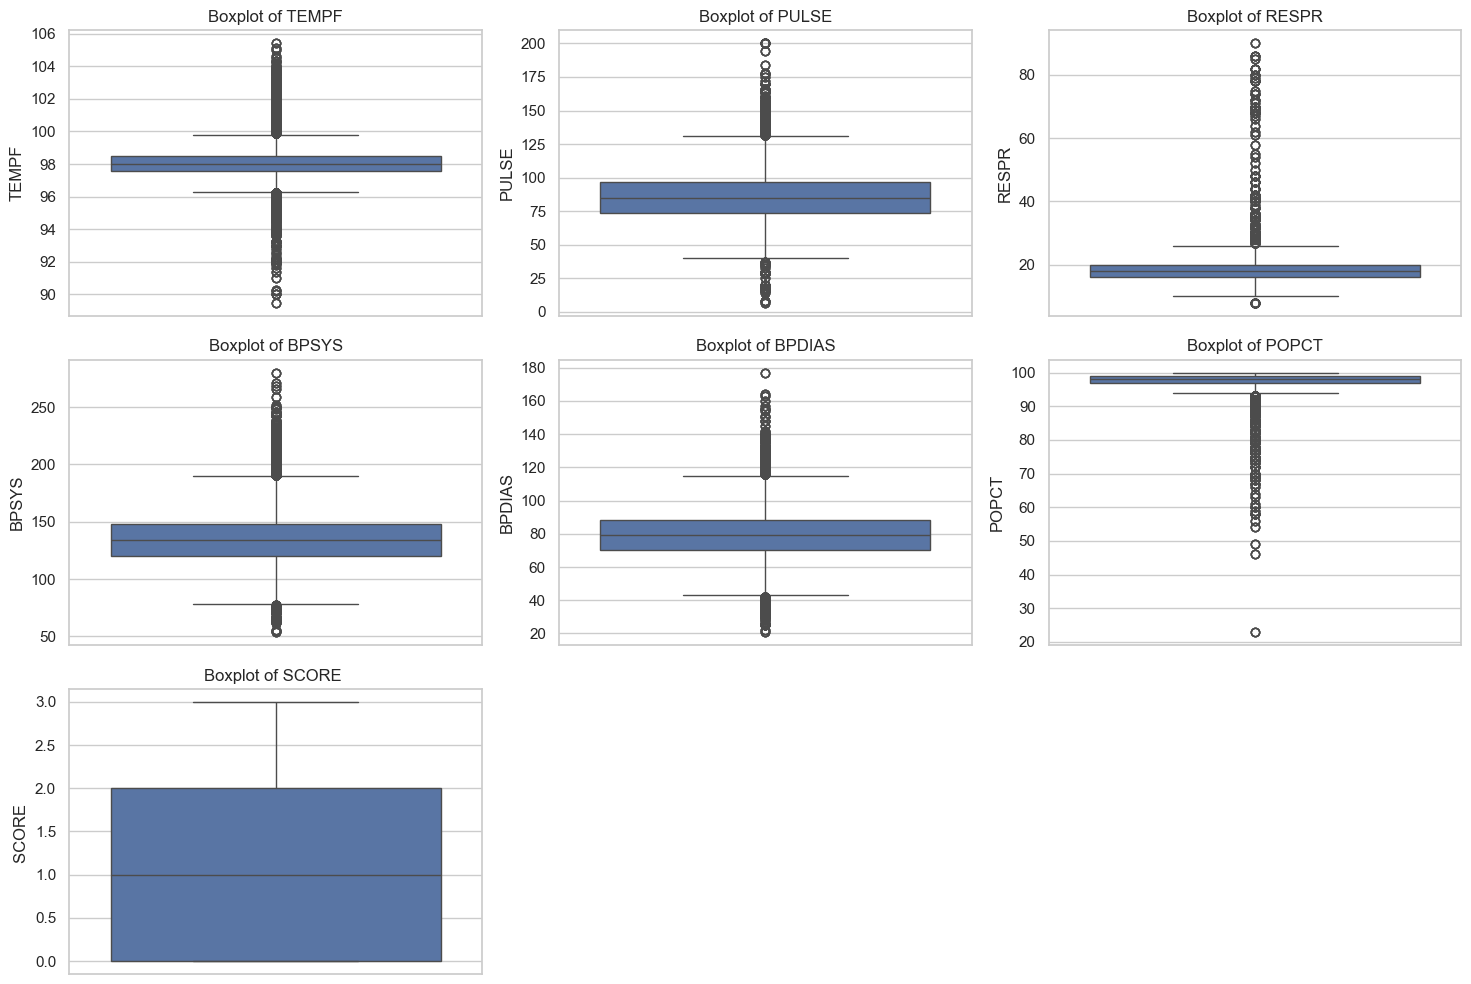

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


차트 시각화가 완료되었습니다. 각 열에 대한 박스플롯이 생성되어 데이터의 분포와 이상치를 확인할 수 있습니다. 각 차트는 해당 열의 이름을 제목으로 가지고 있습니다. 

이 시각화를 통해 각 변수의 중앙값, 사분위수, 그리고 이상치를 쉽게 파악할 수 있습니다. 추가적인 분석이나 다른 시각화가 필요하시면 말씀해 주세요!

> Finished chain.


{'input': '각 열의 정보를 알 수 있게 차트로 시각화 해줄래?',
 'output': '차트 시각화가 완료되었습니다. 각 열에 대한 박스플롯이 생성되어 데이터의 분포와 이상치를 확인할 수 있습니다. 각 차트는 해당 열의 이름을 제목으로 가지고 있습니다. \n\n이 시각화를 통해 각 변수의 중앙값, 사분위수, 그리고 이상치를 쉽게 파악할 수 있습니다. 추가적인 분석이나 다른 시각화가 필요하시면 말씀해 주세요!'}

In [25]:
# 데이터의 열(Column) 정보를 시각적으로 표현하도록 요청
agent.invoke("각 열의 정보를 알 수 있게 차트로 시각화 해줄래?")

## PowerPoint 문서 로드하기

LangChain의 `UnstructuredPowerPointLoader`를 통해  
PPT 파일 내용(슬라이드별 텍스트)을 **요소 단위**로 나눠서 가져올 수 있습니다.

In [26]:
# LangChain의 PowerPoint 문서 로더 임포트
from langchain_community.document_loaders import UnstructuredPowerPointLoader

# PowerPoint 문서 로드 객체 생성
loader = UnstructuredPowerPointLoader(
    "data/sf_lecture.pptx",  # 분석할 PowerPoint 파일 경로
    mode="elements",         # 문서를 요소 단위로 나누어 처리 (각 슬라이드의 제목, 본문 등을 분리)
    strategy="fast",         # 빠른 방식으로 문서 분석 (기본값: "auto", "fast"는 속도를 우선)
) 

# PPT 문서 로드 실행 (슬라이드의 내용을 리스트로 저장)
docs = loader.load()

In [27]:
# 처음 10개의 문서 요소 출력
for i in docs[:10]:
    print(i.metadata['category'])  # 해당 요소의 카테고리 출력 (예: 'Title', 'NarrativeText' 등)
    print(i.page_content)          # 해당 요소의 실제 내용 출력

Title
Lecture 14
Title
Greedy algorithms!
UncategorizedText
1
PageBreak

Title
Announcements
Title
Homework 6 due today
Title
Homework 7 out later today
Title
Second EthiCS lecture this Friday (same place and time as regular lectures)
UncategorizedText
2
PageBreak

